In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (150,150,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.02

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,n-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.add_tissue_sphere((0+0.01,pos-0.01,0), 4, myocardium)
# test_phantom.add_tissue_sphere((-pos,2*pos,0), 6, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


(115, 75, 50)
(95, 95, 50)


514


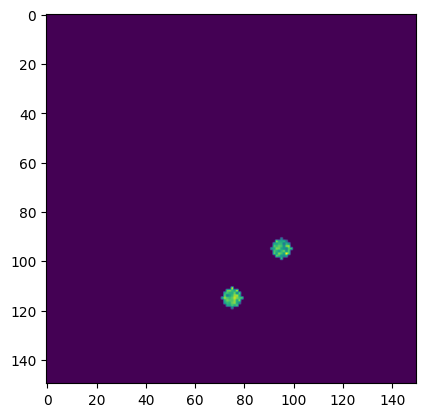

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [25]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

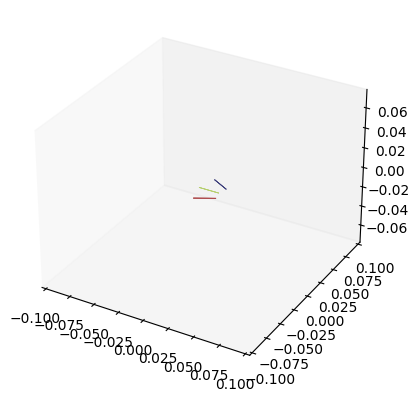

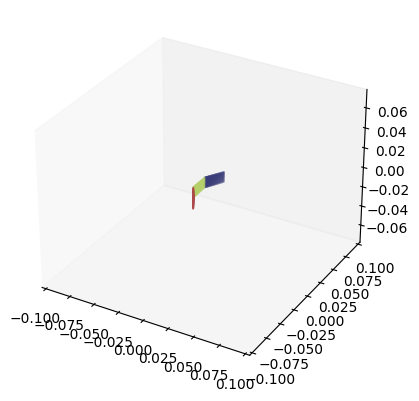

In [26]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))
cont_transducer_set.assign_pose(1, geometry.Transform(translation=[-0.005,0,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-2*np.pi/6,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([2*np.pi/6,0,0], [0,-0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.01,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

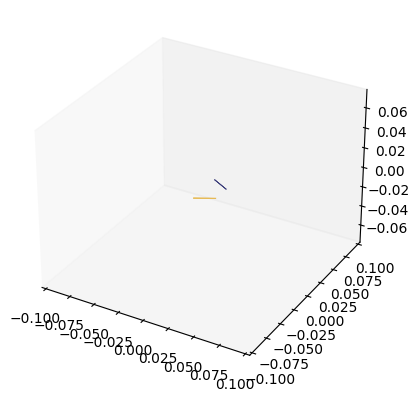

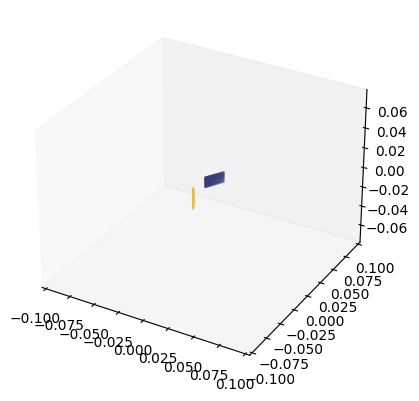

In [23]:
num_transducers = 2
transducers_copy = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers_copy:
    t.make_sensor_coords(test_phantom.baseline[0])
gap_transducer_set = transducer_set.TransducerSet(transducers_copy, seed=8888)
gap_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
gap_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))

gap_transducer_set.plot_transducer_fovs(scale=0.1)
gap_transducer_set.plot_transducer_coords(scale=0.1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


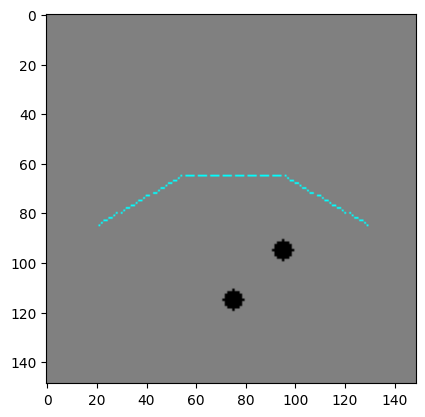

In [28]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')
gap_sensor = sensor.Sensor(transducer_set=gap_transducer_set, aperture_type='extended_aperture')
gm = extended_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

#gm2 = gap_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

In [29]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [32]:
extended_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/extended_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/tar_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

gap_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/gap_experiment_ea',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = gap_transducer_set,
                 sensor          = gap_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

extended_experiment.save()
tar_experiment.save()
gap_experiment.save()

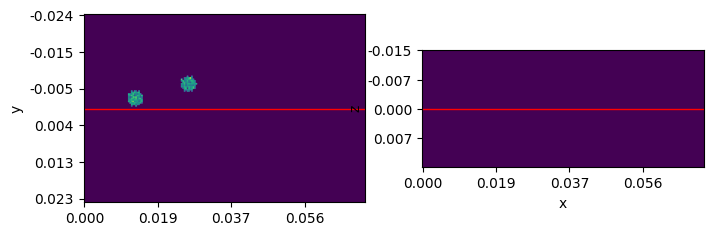

In [35]:
gap_experiment.plot_ray_path(0)

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)